# 1. Player's statistics

## 1.1 Map-independent stats

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

test = pd.read_csv('../scrape-parse/demo/parse/2022/kills/BLAST-Premier-Fall-Final-2022-faze-vs-heroic-bo3faze-vs-heroic-m1-ancient.dem.csv')
test.columns

Index(['Unnamed: 0', 'tick', 'seconds', 'clockTime', 'attackerSteamID',
       'attackerName', 'attackerTeam', 'attackerSide', 'attackerX',
       'attackerY', 'attackerZ', 'attackerViewX', 'attackerViewY',
       'victimSteamID', 'victimName', 'victimTeam', 'victimSide', 'victimX',
       'victimY', 'victimZ', 'victimViewX', 'victimViewY', 'assisterSteamID',
       'assisterName', 'assisterTeam', 'assisterSide', 'isSuicide',
       'isTeamkill', 'isWallbang', 'penetratedObjects', 'isFirstKill',
       'isHeadshot', 'victimBlinded', 'attackerBlinded', 'flashThrowerSteamID',
       'flashThrowerName', 'flashThrowerTeam', 'flashThrowerSide', 'noScope',
       'thruSmoke', 'distance', 'isTrade', 'playerTradedName',
       'playerTradedTeam', 'playerTradedSteamID', 'playerTradedSide', 'weapon',
       'weaponClass', 'roundNum', 'matchID', 'mapName'],
      dtype='object')

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os


pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 70)

# ---------- Prepare data ---------- #

killdemo = os.listdir('../scrape-parse/demo/parse/2022/kills/')
kills = pd.DataFrame()

for i in range(0,700):
    temp = pd.read_csv('../scrape-parse/demo/parse/2022/kills/' + killdemo[i])
    kills = pd.concat([kills, temp])

kills['attackerName'] = kills['attackerName'].str.strip()
kills = kills.reset_index(drop=True)
kills['one'] = 1
# kills = kills.loc[kills['attackerName'].isna() == False]





# ---------- Player stats ---------- #

players = pd.DataFrame(kills[['attackerName']])
players['attackerName'] = players['attackerName'].str.strip()
players = players.drop_duplicates(subset=['attackerName']).reset_index(drop=True).sort_values(by=['attackerName'])

# Matches played
kills['matches_played'] = kills.drop_duplicates(subset=['attackerName','matchID']).groupby(by=['attackerName'])['one'].transform('sum')
kill_test = kills.loc[kills['matches_played'].notna() == True].drop_duplicates(subset=['attackerName'])
players = players.merge(kill_test[['attackerName','matches_played']], on='attackerName', how='left')

# Kill count
kills['kill_count'] = kills.groupby(by=['attackerName'])['one'].transform('sum')
players = players.merge(kills[['attackerName','kill_count']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

# KPM - kills per match
players['KPM'] = players['kill_count'] / players['matches_played']

# KPR - kills per round
rounds = kills[['matchID','roundNum']].sort_values(by=['matchID','roundNum']).drop_duplicates(subset=['matchID'],keep='last').rename(columns={'roundNum':'rounds_played'})
kills = kills.merge(rounds, on='matchID', how='left')
kills['KPM'] = kills[['attackerName','matchID','one']].groupby(by=['attackerName','matchID'])['one'].transform('sum')
kills['KPR_match'] = kills['KPM'] / kills['rounds_played']
kills['KPR'] = kills[['attackerName','KPR_match']].groupby(by=['attackerName'])['KPR_match'].transform('mean')
players = players.merge(kills[['attackerName','KPR']].drop_duplicates(subset=['attackerName']), on='attackerName', how='left')

pd.set_option('display.max_rows', 100)
players.sort_values(by=['KPR'], ascending=False)

,attackerName,matches_played,kill_count,KPM,KPR
183,s1mple,90.0,1973.0,21.922222,0.873311
85,XANTARES,11.0,228.0,20.727273,0.867409
89,ZywOo,87.0,1898.0,21.816092,0.864294
18,F1ku,11.0,249.0,22.636364,0.859735
187,sh1ro,35.0,719.0,20.542857,0.853695
...,...,...,...,...,...
178,raalz,12.0,159.0,13.250000,0.503488
55,NEKIZ,5.0,54.0,10.800000,0.497812
60,PKL,5.0,47.0,9.400000,0.472763
169,npl,3.0,35.0,11.666667,0.457633


<Axes: >

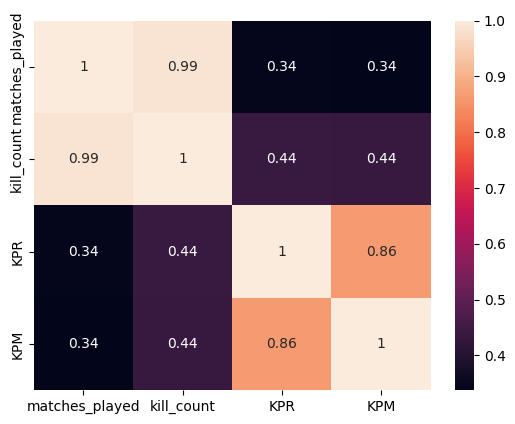

In [31]:
import seaborn as sns

sns.heatmap(players[['matches_played','kill_count','KPR','KPM']].corr(), annot=True)

/home/szmp/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1184: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


(0.0, 30.0)

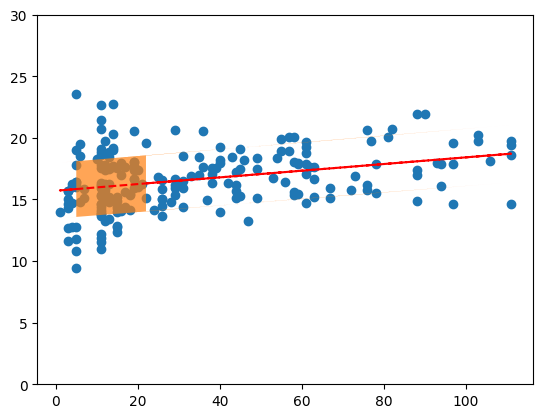

In [53]:
import matplotlib.pyplot as plt
from sklearn.linear_model import BayesianRidge

players_plot = players.loc[players['attackerName'].notna() == True]

reg = BayesianRidge()
reg.fit(players_plot[['matches_played']],players_plot[['KPM']])
ymean, ystd = reg.predict(players_plot[['matches_played']], return_std=True)

plt.scatter(players_plot['matches_played'],players_plot['KPM'])
plt.plot(players_plot[['matches_played']],ymean,'r--')
plt.fill_between(players_plot['matches_played'], ymean-ystd, ymean+ystd, alpha=0.7)
plt.ylim(0,30)